In [3]:
from pathlib import Path
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Embedding, Input, Flatten, Layer, Lambda
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow import keras
from datetime import datetime
from IPython.display import Image
from collections import deque
from statsmodels.tsa.arima_model import ARIMA
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import itertools
import copy
import random
import pickle
import time
import os
import io
from importnb import Notebook, reload
with Notebook(): 
    import Utilities

# This removes error from the custom keras-layer
tf.compat.v1.disable_eager_execution()

In [4]:
def preprocess_text(df):
    """ Tokenize """
    conc = pd.DataFrame()
    for i in set(df.index):
        concat_str = ''
        for title in df.loc[i]['title']:
            concat_str += " " + title.lower()
        concat_str = word_tokenize(concat_str)
        conc = conc.append({'date':i, 'title':concat_str},ignore_index=True)
    conc.set_index('date',inplace=True)
    conc = conc.sort_values('date')
    sents = [''.join([word + ' ' for word in title]) for title in conc['title'].values]
    return sents

def eval_preds(preds,targets): 
    """ Calculate the MSE of the ARIMA-predictions 
    and the actual prices """
    return (np.square(preds - targets)).mean(axis=0)


In [5]:
config = {
    'embed_dim': 300,    # Dimensions to use for the word embedding
    'lookback': 3,       # How far back to collect data in the recurrent layer (days)
    'delay': 1,          # How far ahead to predict data (days)
    'batch_size': 10,    # Batch size used in generator
    'p': 1,              # Order of the AR-part of the model
    'd': 1,              # Integrated order
    'q': 1,              # Included moving average terms 
    'train_part' : 0.8,  # Part of data to be used for training
    'val_part' : 0.1,    # Part of data to be used for validation
    'test_part' : 0.1,   # Part of data to be used for testing
    'series': 'S&P',     # What series we currently want to predict, '1 YEAR', '3 YEAR' or 'S&P'
    'vocab_size': 15000, # Include only the 'vocab_size' most common words 
    'start_date': '2006-10-20',
    'end_date': '2013-11-19',
}

In [6]:
# Load data 
news_path = Path("../Datasets/data/financial_headlines_20061020-20131119.pkl")
stock_path = Path("../Datasets/data/stock_data.pkl")
data = pd.DataFrame(pd.read_pickle(news_path))
data.set_index('date',inplace=True)
stock_data = pd.DataFrame(pd.read_pickle(stock_path))
text = preprocess_text(data)

In [7]:
# Tokenize the text data 
tokenizer = Tokenizer(num_words=config['vocab_size'])
tokenizer.fit_on_texts(text)
word_index = tokenizer.word_index
sequences = tokenizer.texts_to_sequences(text)

In [8]:
# Load dictionary of embeddings for this vocabulary (previously constructed)
subset_embeddings = Path("../Embeddings/GloVe/saved.42B.300d.pkl")
with open(subset_embeddings,'rb') as handle: 
    emb_dict = pickle.load(handle)

In [9]:
# Create embedding matrix with shape (vocab_size, embed_dimension)
embedding_weights = np.zeros((config['vocab_size'], config['embed_dim']))
# Add pre-trained weights from GloVe
for word,index in word_index.items(): 
    if index > config['vocab_size']: 
        break
    temp_emb = emb_dict.get(word)
    if temp_emb is not None: 
        embedding_weights[index - 1] = temp_emb
    else: 
        embedding_weights[index - 1] = np.random.normal(size=config['embed_dim'])

In [10]:
config['max_len'] = max([len(sent) for sent in sequences])
print("Actual maximum length of one day news:",config['max_len'])
#config['max_len'] = 600
print("Used maximum length of one day news:",config['max_len'])

# Pad the text data so we get a matrix of shape (n,d)
x = np.zeros((len(sequences), config['max_len']))
for i,sent in enumerate(sequences): 
    if len(sent) > config['max_len']: 
        x[i] = sent[:config['max_len']]
    else: 
        x[i,:len(sent)] = sent

Actual maximum length of one day news: 950
Used maximum length of one day news: 950


In [13]:
y = Utilities.load_financial_labels(config)

Found and loaded previously constructed ARIMA-models.


In [14]:
(x_train,y_train), (x_test, y_test) = Utilities.shuffle_and_partition(x,y, test_part=0.2)
print("Shape of x_train: ",x_train.shape)
print("Shape of y_train: ",y_train.shape)

Shape of x_train:  (2060, 950)
Shape of y_train:  (2060,)


## Model
We create a model similar to the one in "MLP-PreTrained", except for the initial Embedding-layer from Keras. A custom layer is defined to average the embedding of all words in one training sample after the embedding layer. 

In [15]:
# Define some help functions for custom layer and hyper parameter optimization

# Create functions for custom 'MergeEmedding'-layer which averages 
# the embeddings over all words after the embedding layer 
def merge_embeddings(x):
    # Sum the embeddings for every word slot. If this is zero, there is no word in this slot
    non_zero = K.sum(K.cast(K.not_equal(K.sum(x,axis=2),0),tf.float32))
    return K.sum(x,axis=1) / non_zero

def merge_output_shape(input_shape):
    return input_shape[0], input_shape[-1]

def create_nn(n_nodes, activation='relu'): 
    # n_nodes is a list with the number of nodes per layer, starting from the input 
    input_layer = Input(shape=config['max_len'], name='input')
    embed_layer = Embedding(input_dim=config['vocab_size'],
                    output_dim=config['embed_dim'],
                    weights=[embedding_weights])(input_layer)
    prev_layer = Lambda(merge_embeddings, output_shape=merge_output_shape)(embed_layer)
    for n in n_nodes: 
        prev_layer = Dense(n, activation=activation)(prev_layer)
    output_layer = Dense(1, activation='linear', name='output')(prev_layer)
    model = Model(inputs=[input_layer], outputs=[output_layer])
    model.compile(optimizer='rmsprop', loss='mse')
    return model

def train_and_format(x,y,bs,epochs, results, layers, nodes,verbose=0):
    name = f"{bs}_{layers}_{nodes}"
    temp_history = model.fit(x, y, batch_size=bs, validation_split=0.2, epochs = epochs,verbose=verbose)
    return results.append(pd.Series([np.mean(temp_history.history['val_loss'][-5:]),
                                                temp_history, model, layers, 
                                                nodes, bs], 
                                                name=name,index=['Mean Val MSE','History','Model','Layers','Nodes','Batch Size']))


In [83]:
n_layers = np.arange(2,3)
n_nodes = [1,5,10]
batch_sizes = [8, 12, 16]
epochs = 10
results = pd.DataFrame(columns=['Mean Val MSE','History','Model', 'Layers', 'Nodes','Batch Size'])
n_configs = sum([len(n_nodes)**l for l in n_layers]) * len(batch_sizes)
ctr = 0
print('Testing {} combinations. '.format(n_configs))
for layers in n_layers:
    # Ugliest code ever written, fix?
    if layers == 1: node_configs = list(itertools.product(n_nodes))
    elif layers == 2: node_configs = list(itertools.product(n_nodes, n_nodes))
    elif layers == 3: node_configs = list(itertools.product(n_nodes, n_nodes, n_nodes))
    elif layers == 4: node_configs = list(itertools.product(n_nodes, n_nodes, n_nodes, n_nodes))
    for bs in batch_sizes: 
        for temp_nodes in node_configs: 
            ctr += 1 
            print("{} %     ".format(round(100 * ctr / n_configs,2)),end='\r')
            model = create_nn(temp_nodes)
            results = train_and_format(x_train, y_train, bs, epochs, results, layers, temp_nodes,verbose=0)


Testing 27 combinations. 


In [87]:
k = 5
print("Top {} configs: ".format(k))
k_best = np.argpartition(results['Mean Val MSE'],k)[:k]
k_best = pd.DataFrame(results.iloc[k_best])
k_best

Top 5 configs: 


,Mean Val MSE,History,Model,Layers,Nodes,Batch Size
"12_2_(1, 10)",0.000105,<tensorflow.python.keras.callbacks.History obj...,<tensorflow.python.keras.engine.training.Model...,2,"(1, 10)",12
"8_2_(1, 5)",0.000105,<tensorflow.python.keras.callbacks.History obj...,<tensorflow.python.keras.engine.training.Model...,2,"(1, 5)",8
"8_2_(10, 1)",0.000105,<tensorflow.python.keras.callbacks.History obj...,<tensorflow.python.keras.engine.training.Model...,2,"(10, 1)",8
"12_2_(1, 1)",0.000105,<tensorflow.python.keras.callbacks.History obj...,<tensorflow.python.keras.engine.training.Model...,2,"(1, 1)",12
"8_2_(5, 10)",0.000105,<tensorflow.python.keras.callbacks.History obj...,<tensorflow.python.keras.engine.training.Model...,2,"(5, 10)",8


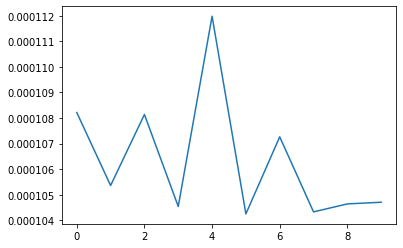

12_2_(1, 10)


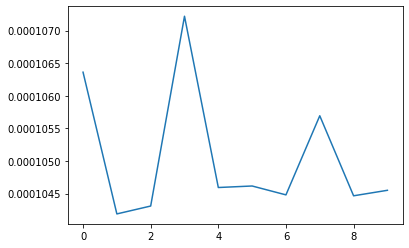

8_2_(1, 5)


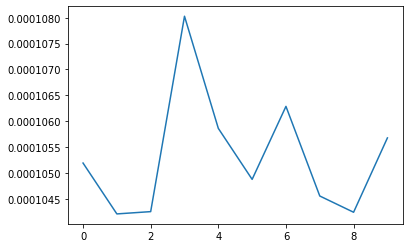

8_2_(10, 1)


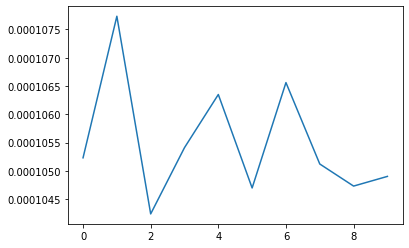

12_2_(1, 1)


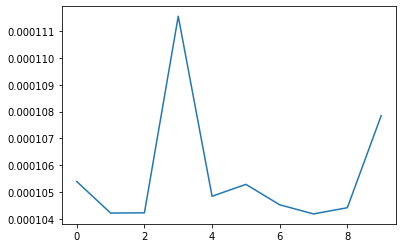

8_2_(5, 10)


In [88]:
k = 5
k_best = np.argpartition(results['Mean Val MSE'],k)[:k]
for i in k_best: 
    plt.plot(results.iloc[i]['History'].history['val_loss'])
    plt.show()
    print(results.index[i])

In [89]:
best = np.argpartition(results['Mean Val MSE'],1)[1]
model_test = results.iloc[best]['Model'].evaluate(x_test,y_test,verbose=0)
zero_test = np.dot(y_test,y_test) / len(y_test)
print("Model test score:",model_test)
print("Zero test score:",zero_test)

Model test score: 0.00011808914244734429
Zero test score: 0.00011807464709233143


In [93]:
results.iloc[best]['Model'].summary()

Model: "model_49"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 950)]             0         
_________________________________________________________________
embedding_51 (Embedding)     (None, 950, 300)          4500000   
_________________________________________________________________
lambda_43 (Lambda)           (None, 300)               0         
_________________________________________________________________
dense_92 (Dense)             (None, 1)                 301       
_________________________________________________________________
dense_93 (Dense)             (None, 10)                20        
_________________________________________________________________
output (Dense)               (None, 1)                 11        
Total params: 4,500,332
Trainable params: 4,500,332
Non-trainable params: 0
________________________________________________